<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
!nvidia-smi

Thu May 27 05:56:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
# !pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

/content/segmentation-of-pelvic-bone/src


In [3]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/KenzaB27/segmentation-of-pelvic-bone
   8ce1901..e6a6d35  main       -> origin/main
Updating 8ce1901..e6a6d35
Fast-forward
 src/analysis.py | 3 +--
 1 file changed, 1 insertion(+), 2 deletions(-)


In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [5]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [6]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 15.7 s, sys: 4.48 s, total: 20.2 s
Wall time: 21.2 s


In [7]:
data.cmn_img_3c[42].shape

(291, 512, 512, 3)

In [8]:
print(f"X train shape:{data.X_train_3C.shape}, y train shape:{data.y_train.shape} ")
print(f"X val shape:{data.X_val_3C.shape}, y val shape:{data.y_val.shape} ")

X train shape:(772, 512, 512, 3), y train shape:(772,) 
X val shape:(86, 512, 512, 3), y val shape:(86,) 


In [19]:
print('Min: %.3f, Max: %.3f' % (data.cmn_img[42].min(), data.cmn_img[42].max()))

Min: -1024.000, Max: 3071.000


In [10]:
print('Min: %.3f, Max: %.3f' % (data.X_val_3C.min(), data.X_val_3C.max()))

Min: -2.628, Max: 1.531


In [11]:
print('Min: %.3f, Max: %.3f' % (data.X_flat_val.min(), data.X_flat_val.max()))

Min: -2.628, Max: 1.531


In [20]:
X = data.X_flat_train.reshape(data.X_train.shape)
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))
X_3c = np.array(
            [np.repeat(x[None, ...], 3, axis=0).T for x in X])
print('Min: %.3f, Max: %.3f' % (X_3c.min(), X_3c.max()))

Min: 0.000, Max: 1.000
Min: 0.000, Max: 1.000


In [20]:
X_train, y_train, X_val, y_val = data.X_train_3C, data.y_train, data.X_val_3C, data.y_val

## VGG 16

In [21]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tf.image.per_image_standardization(x)
vgg_model = tfk.applications.VGG16(weights="imagenet", include_top=False, pooling="max")
vgg_output = vgg_model(x)
hidden_layer = tfkl.Dense(512, activation='relu')(vgg_output)
hl_reg = tfkl.Dropout(0.4)(hidden_layer)
# hidden_layer = tfkl.Dense(256, activation='relu')(hl_reg)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, None, None, 3)     0         
_________________________________________________________________
tf.image.per_image_standardi (None, None, None, 3)     0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513   

### Training 

In [23]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="SGD", loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
checkpoint_filepath = PATH + '/checkpoint/vgg/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/25


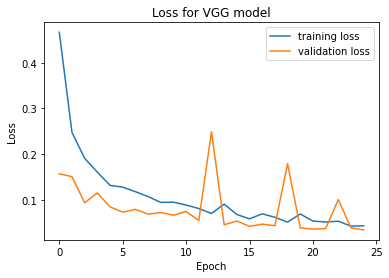

In [32]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

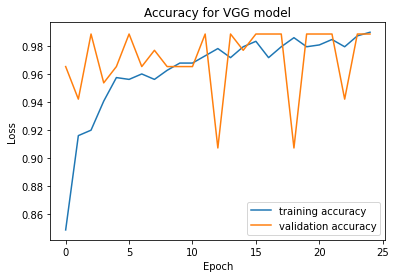

In [33]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Performance on Common Images

In [35]:
cmn_img.shape

(286, 512, 512, 3)

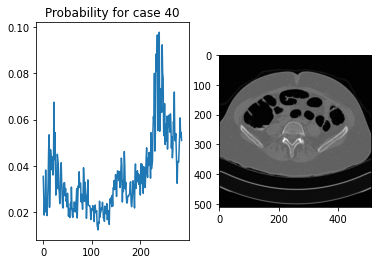

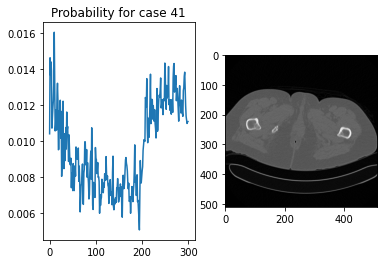

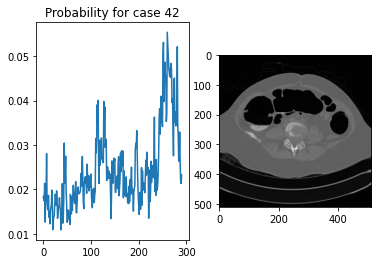

CPU times: user 24.3 s, sys: 3.24 s, total: 27.5 s
Wall time: 27.1 s


In [36]:
%%time
for id, cmn_img in data.cmn_img.items():
  X = np.clip(cmn_img, -125, 275)
  X_flat = np.array([x.flatten() for x in X])
  X_flat = data.scaler.transform(X_flat)
  X = X_flat.reshape(X.shape)
  X = np.array(
            [np.repeat(x[None, ...], 3, axis=0).T for x in X])
  y_pred = model.predict(X)
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()

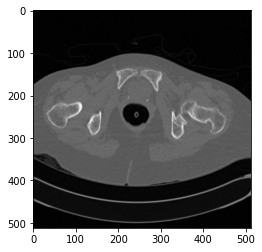

In [ ]:
plt.imshow(data.cmn_img[42][48], cmap="gray")

In [ ]:
model.predict(data.cmn_img_3c[42][48].reshape(1,512,512,3))

array([[0.]], dtype=float32)